# Titanic ML

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplot
from matplotlib import rcParams
import seaborn as sns
import re
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix


#from sklearn.cross_validation import KFold, cross_val_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import roc_curve, accuracy_score, make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV

from sklearn import ensemble
from sklearn import tree

rcParams['figure.figsize'] = (10, 8)

In [2]:
sub = pd.read_csv('gender_submission.csv')
testing = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

target = 'Survived'

test = testing.copy()

#checking data type and null values, overview of dataset
test.info()
print('-'*70)
train.info()
print('-'*70)
sub.info()
print('-'*70)
train.tail(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int6

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
881,882,0,3,"Markun, Mr. Johann",male,33.0,0,0,349257,7.8958,NaN,S
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
883,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.7500,NaN,Q


In [3]:
#feature engineering
def title(i):
    i['Title'] = i.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
    i['Title'] = i['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'})
    i['Title'] = i['Title'].replace(['Don', 'Dona', 'Rev', 'Dr',
                                                'Major', 'Lady', 'Sir', 'Col', 'Capt', 'Countess', 'Jonkheer'],'Special')
title(train)
title(test)
#---------------------------------------------------------------------------------------------------------------------------------------

def fillna_median_age(i, u):
    i[u] = i.groupby(['Sex', 'Title'])[u].apply(lambda x: x.fillna(x.median()))
    
fillna_median_age(train,'Age')
fillna_median_age(test,'Age')
#---------------------------------------------------------------------------------------------------------------------------------------

def fillna_median_fare(i, u):
    i[u] = i.groupby(['Pclass', 'Title'])[u].apply(lambda x: x.fillna(x.median()))
    
fillna_median_fare(test,'Fare')
#---------------------------------------------------------------------------------------------------------------------------------------

train['Embarked'] = train['Embarked'].fillna("S")
#---------------------------------------------------------------------------------------------------------------------------------------

def family_size(x):
    x['Family'] =  x["Parch"] + x["SibSp"]

family_size(train)
family_size(test)

In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Family
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.393008,0.523008,0.381594,32.204208,0.904602
std,257.353842,0.486592,0.836071,13.269209,1.102743,0.806057,49.693429,1.613459
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,21.000000,0.000000,0.000000,7.910400,0.000000
50%,446.000000,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200,0.000000
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,10.000000


In [5]:
# Preparing features for analysis
dummy_features = ['Sex','Embarked','Title']
drop_features = ['PassengerId', 'Ticket', 'Name', 'Cabin','Parch','SibSp']
    
train = pd.concat([train, pd.get_dummies(train[dummy_features])], axis = 1, sort = False)
train.drop(columns = train[dummy_features], inplace = True)
train.drop(columns = train[drop_features], inplace = True)

test = pd.concat([test, pd.get_dummies(test[dummy_features])], axis = 1, sort = False)
test.drop(columns = test[dummy_features], inplace = True)
test.drop(columns = test[drop_features], inplace = True)

train.tail()

,Survived,Pclass,Age,Fare,Family,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Special
886,0,2,27.0,13.00,0,0,1,0,0,1,0,0,0,0,1
887,1,1,19.0,30.00,0,1,0,0,0,1,0,1,0,0,0
888,0,3,21.0,23.45,3,1,0,0,0,1,0,1,0,0,0
889,1,1,26.0,30.00,0,0,1,1,0,0,0,0,1,0,0
890,0,3,32.0,7.75,0,0,1,0,1,0,0,0,1,0,0


In [6]:
#last check for NaN values in dataset and check if column amount is the same in both datasets
train.info()
print('-'*70)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
Survived         891 non-null int64
Pclass           891 non-null int64
Age              891 non-null float64
Fare             891 non-null float64
Family           891 non-null int64
Sex_female       891 non-null uint8
Sex_male         891 non-null uint8
Embarked_C       891 non-null uint8
Embarked_Q       891 non-null uint8
Embarked_S       891 non-null uint8
Title_Master     891 non-null uint8
Title_Miss       891 non-null uint8
Title_Mr         891 non-null uint8
Title_Mrs        891 non-null uint8
Title_Special    891 non-null uint8
dtypes: float64(2), int64(3), uint8(10)
memory usage: 43.6 KB
----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
Pclass           418 non-null int64
Age              418 non-null float64
Fare             418 non-null float64
F

In [7]:
# Separating target column from other features
y = train[target]
x = train.drop(columns = target)

# Train and Test dataset split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 42)

### Random Forest Classifier

In [16]:
# Cross Validation Random Forest
from sklearn.model_selection import cross_val_score

RF_cv = ensemble.RandomForestClassifier(n_estimators=10, max_depth=10)
scores = cross_val_score(RF_cv, x_train, y_train, cv=10)
for iter_count, accuracy in enumerate(scores):
    print('cross validation {0} accuracy: {1:.4f}'.format(iter_count, accuracy))
    
print('RandomForestClassifier mean accuracy: {0:.4f}'.format(np.mean(scores)))

cross validation 0 accuracy: 0.7794
cross validation 1 accuracy: 0.7059
cross validation 2 accuracy: 0.8382
cross validation 3 accuracy: 0.8209
cross validation 4 accuracy: 0.7910
cross validation 5 accuracy: 0.7727
cross validation 6 accuracy: 0.8333
cross validation 7 accuracy: 0.8636
cross validation 8 accuracy: 0.7727
cross validation 9 accuracy: 0.9091
RandomForestClassifier mean accuracy: 0.8087


Best Hyper Parameters:  {'max_depth': 5, 'n_estimators': 100, 'random_state': 42}
Best Score: 0.832
RF accuracy: 0.825
AUC: 0.885


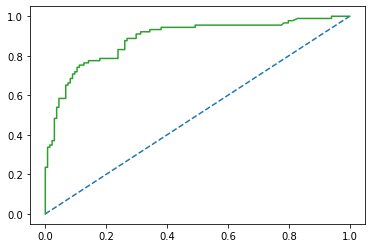

In [9]:
# random forest model hyper-tuned

RF = ensemble.RandomForestClassifier()



RF_params = {
          'n_estimators':[n for n in range(70,130,10)],
          'max_depth':[n for n in range(2, 10)],
          #'min_samples_leaf': [n for n in range(2, 6, 2)],
          'random_state' : [42]
            }


RF_model = GridSearchCV(RF, param_grid = RF_params, cv = 3, n_jobs = -1, scoring='accuracy')
RF_model.fit(x_train, y_train)

print("Best Hyper Parameters: ", RF_model.best_params_)
print("Best Score: " + '%.3f' % RF_model.best_score_)

RF_predictions = RF_model.predict(x_test)
RF_accuracy = accuracy_score(y_test, RF_predictions)
print("RF accuracy: " + '%.3f' % RF_accuracy)

# Area under the curve probability score
RF_probs = RF_model.predict_proba(x_test)
RF_probs = RF_probs[:, 1]
RF_auc = roc_auc_score(y_test, RF_probs)
print('AUC: %.3f' % RF_auc)

# AUC plot
RF_fpr, RF_tpr, RF_thresholds = roc_curve(y_test, RF_probs)
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(RF_fpr, RF_tpr, color = 'tab:green');

### Gradient Bossting Classifier

In [20]:
# Cross Validation Gradient Boosting
from sklearn.model_selection import cross_val_score

GBT_cv = ensemble.GradientBoostingClassifier(n_estimators=10, max_depth=10)
scores = cross_val_score(GBT_cv, x_train, y_train, cv=10)
for iter_count, accuracy in enumerate(scores):
    print('cross validation {0} accuracy: {1:.4f}'.format(iter_count, accuracy))
    
print('GradientBoostingClassifier mean accuracy: {0:.4f}'.format(np.mean(scores)))
    
 

cross validation 0 accuracy: 0.7500
cross validation 1 accuracy: 0.7647
cross validation 2 accuracy: 0.8235
cross validation 3 accuracy: 0.7910
cross validation 4 accuracy: 0.7910
cross validation 5 accuracy: 0.7576
cross validation 6 accuracy: 0.7879
cross validation 7 accuracy: 0.8030
cross validation 8 accuracy: 0.7727
cross validation 9 accuracy: 0.7727
GradientBoostingClassifier mean accuracy: 0.7814


Best Hyper Parameters:  {'max_depth': 2, 'n_estimators': 80, 'random_state': 42}
Best Score: 0.823
GBT accuracy: 0.825
AUC: 0.896


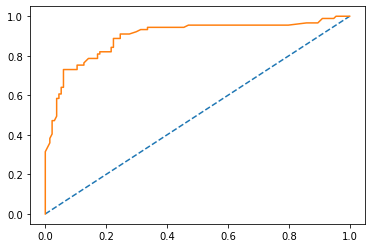

In [11]:
#gradient boosting tree model hyper-tuned

GBT = ensemble.GradientBoostingClassifier()
GBT_params = {
          'n_estimators':[n for n in range(60,120,10)],
          'max_depth':[n for n in range(2, 10)],
          #'min_samples_leaf': [n for n in range(2, 6, 2)],
          'random_state' : [42]
             }

GBT_model = GridSearchCV(GBT, param_grid = GBT_params, cv = 3, n_jobs = -1, scoring='accuracy')
GBT_model.fit(x_train, y_train)
print("Best Hyper Parameters: ",GBT_model.best_params_)
print("Best Score: " + '%.3f' % GBT_model.best_score_)

GBT_predictions = GBT_model.predict(x_test)
GBT_accuracy = accuracy_score(y_test, GBT_predictions)
print("GBT accuracy: " + '%.3f' % GBT_accuracy)

# Area under the curve probability score
GBT_probs = GBT_model.predict_proba(x_test)
GBT_probs = GBT_probs[:, 1]
GBT_auc = roc_auc_score(y_test, GBT_probs)
print('AUC: %.3f' % GBT_auc)

# AUC plot
GBT_fpr, GBT_tpr, GBT_thresholds = roc_curve(y_test, GBT_probs)
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(GBT_fpr, GBT_tpr, color = 'tab:orange');

Scores :
Random Forest AUC: 0.885
Random Forest Best Score: 0.832
RF accuracy: 0.825

Gradient Boosting Classifier AUC: 0.896
Gradient Boosting Classifier Best Score: 0.823
GBT accuracy: 0.825


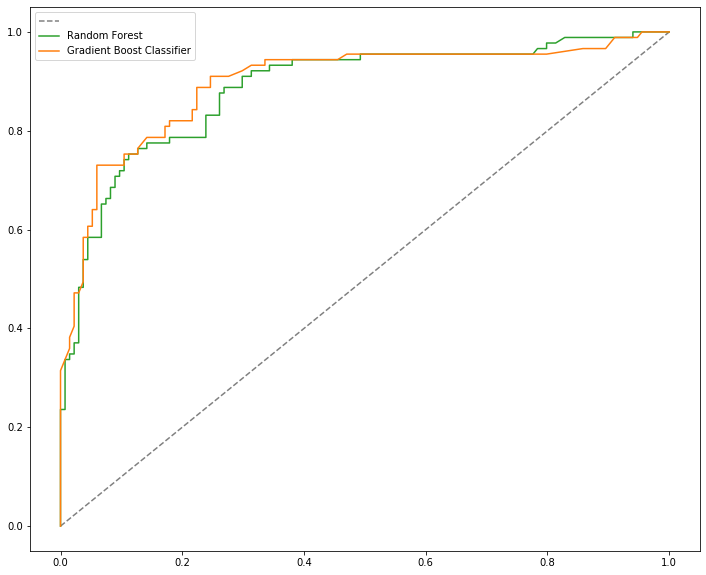

In [21]:
#Area under the curve probability score
b = '\033[1m'
ub = '\033[0m'

pyplot.figure(figsize=[12,10])
print(b + 'Scores :')
print(ub + 'Random Forest AUC: ' + b +  '%.3f' % RF_auc)
print(ub + "Random Forest Best Score: "+ b +   '%.3f' % RF_model.best_score_)
print(ub + "RF accuracy: " + b +   '%.3f' % RF_accuracy)


print(ub + '\nGradient Boosting Classifier AUC: ' + b +  '%.3f' % GBT_auc)
print(ub + "Gradient Boosting Classifier Best Score: " + b +   '%.3f' % GBT_model.best_score_)
print(ub + "GBT accuracy: "+ b +   '%.3f' % GBT_accuracy)


# AUC plot
pyplot.plot([0, 1], [0, 1], linestyle='--', color = 'grey')
pyplot.plot(RF_fpr, RF_tpr, color = 'tab:green')
pyplot.plot(GBT_fpr, GBT_tpr, color = 'tab:orange')

pyplot.legend(('', 'Random Forest', 
                   'Gradient Boost Classifier'))

pyplot.show()

Random Forest  confusion matrix results:
 [[249  17]
 [ 10 142]] 

Random Forest accuracy: 0.935
-------------------------------------------------- 

Gradient Boost  confusion matrix results:
 [[249  17]
 [  6 146]] 

Gradient Boost accuracy: 0.945


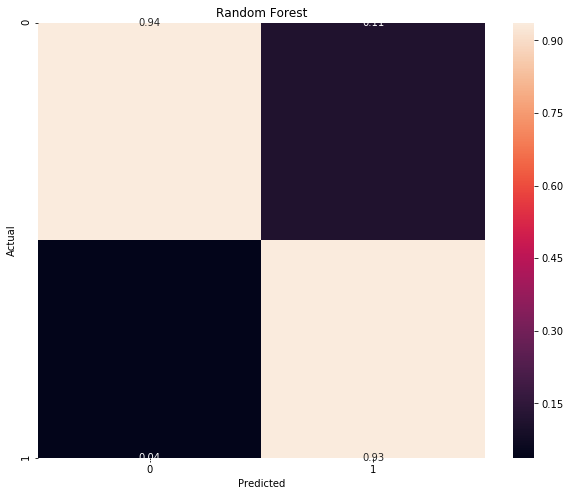

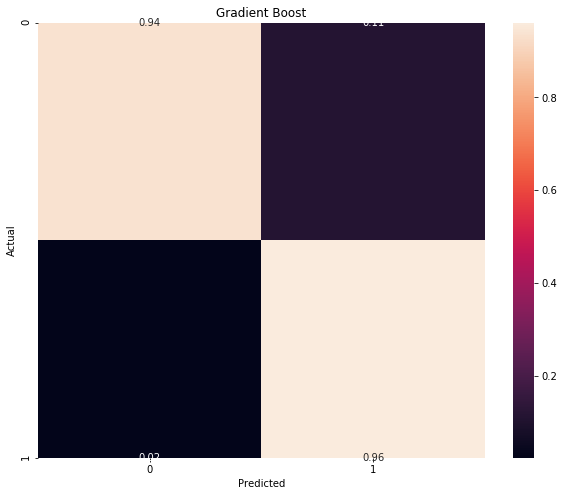

In [13]:
#comparing model predictions to org. submission file
def conf_matrix(x, y):
    prediction = x.predict(test)
    CM = confusion_matrix(sub[target], prediction)
    CM_rel = CM / CM.astype(np.float).sum(axis=1)


    pyplot.figure(figsize=(10,8))
    sns.heatmap(CM_rel, annot = True, fmt='.2f')
    pyplot.ylabel('Actual')
    pyplot.xlabel('Predicted')
    pyplot.title(y);
    
    print(ub + y, ' confusion matrix results:\n', CM, '\n')
    
    pred = accuracy_score(sub[target], prediction)
    print(ub + y + " accuracy: " + b +   '%.3f' % pred)

def checking(x,i):
    prediction = x.predict(test)

    submission = pd.DataFrame({'PassengerId':testing['PassengerId'],'Survived':prediction})
    print("Incorrect predictions from " + str(i) + ": \n" + str(sub.where(sub != submission).count()))
    
    
conf_matrix(RF_model, 'Random Forest')   
#checking(RF_model, 'Random Forest')  
print('-'*50,'\n')
conf_matrix(GBT_model, 'Gradient Boost')
#checking(GBT_model, 'Gradient Boost')

In [14]:
predict_RF = RF_model.predict(test)
predict_GBT = GBT_model.predict(test)

submit_RF = pd.DataFrame({'PassengerId':testing['PassengerId'],'Survived':predict_RF})
submit_GBT = pd.DataFrame({'PassengerId':testing['PassengerId'],'Survived':predict_GBT})


#creating submission file
filename_RF = 'Titanic Prediction RF.csv'
submit_RF.to_csv(filename_RF,index=False)
print('Saved file: ' + filename_RF)

filename_GBT = 'Titanic Prediction GBT.csv'
submit_GBT.to_csv(filename_GBT,index=False)
print('Saved file: ' + filename_GBT)

Saved file: Titanic Prediction RF.csv
Saved file: Titanic Prediction GBT.csv
